## Import packages

In [1]:
import torch
import numpy as np

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn.functional as F

from model import CombNetRW
from dataset import CombinationDatasetRW

from train_rw import EarlyStopping, train_contrastive, train_ce, evaluate, seed_everything

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os

import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/data/project/gujh/miniconda3/envs/dcpred/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare data

In [2]:
seed_everything(42)

In [3]:
# rand_dataset = CombinationDatasetRW(database='DC_combined', embeddingf='DREAMwalk', neg_ratio=1, neg_dataset='random', seed=42)
ts_dataset = CombinationDatasetRW(database='DC_combined', embeddingf='DREAMwalk', neg_ratio=1, neg_dataset='TWOSIDES', seed=42)

# rand_train, rand_valid, rand_test = rand_dataset['train'], rand_dataset['valid'], rand_dataset['test']
ts_train, ts_valid, ts_test = ts_dataset['train'], ts_dataset['valid'], ts_dataset['test']

# rand_test = ConcatDataset([rand_dataset['valid'], rand_dataset['test']])
ts_test = ConcatDataset([ts_dataset['valid'], ts_dataset['test']])

data/processed/DC_combined_embf(DREAMwalk)_neg(TWOSIDES_1)_seed42.pt already exists in processed/ directory.
Loading dataset...data/processed/DC_combined_embf(DREAMwalk)_neg(TWOSIDES_1)_seed42.pt
Dictionary of {train, valid, test, whole} dataset is loaded.


In [4]:
# rand_trainloader = DataLoader(rand_train, batch_size=128, shuffle=True)
# rand_validloader = DataLoader(rand_valid, batch_size=128, shuffle=False)
# rand_testloader = DataLoader(rand_test, batch_size=128, shuffle=False)

ts_trainloader = DataLoader(ts_train, batch_size=128, shuffle=True)
ts_validloader = DataLoader(ts_valid, batch_size=128, shuffle=False)
ts_testloader = DataLoader(ts_test, batch_size=128, shuffle=False)

In [5]:
input_dim = 128
hidden_dim = 128
output_dim = 1

## Train new model for visualization

In [6]:
def train_emb(train_loader, valid_loader, test_loader, ds_name):
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=100)
    parser.add_argument('--ce_lr', type=float, default=1e-3)
    parser.add_argument('--contra_lr', type=float, default=1e-1)
    parser.add_argument('--weight_decay', type=float, default=1e-5)
    args = parser.parse_args(args=[])

    device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')
    ckpt_name = f'ckpt/DREAMwalk_{ds_name}_prod_fc_42'

    contra_model = CombNetRW(input_dim, hidden_dim, output_dim, comb_type='prod_fc').to(device)
    contra_optimizer = torch.optim.Adam(contra_model.parameters(), lr=args.contra_lr, weight_decay=args.weight_decay)
    contra_early_stopping = EarlyStopping(patience=20, verbose=True, path=f'{ckpt_name}_contra.pt')

    for epoch in range(args.epochs):
        train_loss = train_contrastive(contra_model, device, train_loader, contra_optimizer)
        print(f'Contra Epoch {epoch+1:03d}: | Train Loss: {train_loss:.4f}')
        contra_early_stopping(train_loss, contra_model)
        if contra_early_stopping.early_stop:
            print("Early stopping")
            break

    del contra_model
    del contra_optimizer
    del contra_early_stopping
    torch.cuda.empty_cache()

    model = CombNetRW(input_dim, hidden_dim, output_dim, comb_type='prod_fc').to(device)
    model.load_state_dict(torch.load(f'{ckpt_name}_contra.pt'))
    optimizer = torch.optim.Adam(model.parameters(), lr=args.ce_lr, weight_decay=args.weight_decay)
    early_stopping = EarlyStopping(patience=20, verbose=True, path=f'{ckpt_name}.pt')
    criterion = nn.BCEWithLogitsLoss()

    metric_list = [accuracy_score, roc_auc_score, f1_score, average_precision_score, precision_score, recall_score]

    for epoch in range(args.epochs):
        train_loss, train_scores = train_ce(model, device, train_loader, criterion, optimizer, metric_list)
        valid_loss, valid_scores = evaluate(model, device, valid_loader, criterion, metric_list)
        print(f'Epoch {epoch+1:03d}: | Train Loss: {train_loss:.4f} | Train Acc: {train_scores[0]*100:.2f}% | Train Precision: {train_scores[4]:.4f} | Train Recall: {train_scores[5]:.4f} || Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_scores[0]*100:.2f}% | Valid Precision: {valid_scores[4]:.4f} | Valid Recall: {valid_scores[5]:.4f}')
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    test_loss, test_scores = evaluate(model, device, test_loader, criterion, metric_list, checkpoint=f"{ckpt_name}.pt")
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_scores[0]*100:.2f}% | Test Precision: {test_scores[4]:.4f} | Test Recall: {test_scores[5]:.4f}')

In [7]:
# train_emb(rand_trainloader, rand_validloader, rand_testloader, 'random')

In [8]:
train_emb(ts_trainloader, ts_validloader, ts_testloader, 'twosides')

Contra Epoch 001: | Train Loss: 0.4625
Validation loss decreased (inf --> 0.462520).  Saving model ...
Contra Epoch 002: | Train Loss: 0.4344
Validation loss decreased (0.462520 --> 0.434391).  Saving model ...
Contra Epoch 003: | Train Loss: 0.4219
Validation loss decreased (0.434391 --> 0.421897).  Saving model ...
Contra Epoch 004: | Train Loss: 0.4107
Validation loss decreased (0.421897 --> 0.410687).  Saving model ...
Contra Epoch 005: | Train Loss: 0.4128
EarlyStopping counter: 1 out of 20
Contra Epoch 006: | Train Loss: 0.4057
Validation loss decreased (0.410687 --> 0.405664).  Saving model ...
Contra Epoch 007: | Train Loss: 0.4070
EarlyStopping counter: 1 out of 20
Contra Epoch 008: | Train Loss: 0.4053
Validation loss decreased (0.405664 --> 0.405250).  Saving model ...
Contra Epoch 009: | Train Loss: 0.4050
Validation loss decreased (0.405250 --> 0.405039).  Saving model ...
Contra Epoch 010: | Train Loss: 0.3966
Validation loss decreased (0.405039 --> 0.396643).  Saving mod

## Get embeddings for raw, contra, ce

In [9]:
def get_emb(loader, stage, ds_name='random', normalize=False):
    '''
    stage: raw, contra, ce
    '''
    if stage == 'raw':
        emb_pos = []
        emb_neg = []
        for _, (data, target) in enumerate(loader):
            drug1, drug2 = data[:, :input_dim], data[:, input_dim:]
            prod_emb = drug1 * drug2
            emb_pos.append(prod_emb[target==1])
            emb_neg.append(prod_emb[target==0])
        emb_pos = torch.cat(emb_pos, dim=0)
        emb_neg = torch.cat(emb_neg, dim=0)
        print(f'emb_pos: {emb_pos.shape} / emb_neg: {emb_neg.shape}')
        return emb_pos, emb_neg
    else:
        device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')
        model = CombNetRW(input_dim, hidden_dim, output_dim, comb_type='prod_fc').to(device)
        if stage == 'contra':
            model.load_state_dict(torch.load(f'ckpt/DREAMwalk_{ds_name}_prod_fc_42_contra.pt'))
        elif stage == 'ce':
            model.load_state_dict(torch.load(f'ckpt/DREAMwalk_{ds_name}_prod_fc_42.pt'))
        model.eval()
        emb_pos = []
        emb_neg = []
        with torch.no_grad():
            for _, (data, target) in enumerate(loader):
                data, target = data.to(device), target.to(device)
                prod_emb = model.extract_trained_feature(data, normalize)
                emb_pos.append(prod_emb[target==1])
                emb_neg.append(prod_emb[target==0])
        emb_pos = torch.cat(emb_pos, dim=0).cpu()
        emb_neg = torch.cat(emb_neg, dim=0).cpu()
        print(f'emb_pos: {emb_pos.shape} / emb_neg: {emb_neg.shape}')
        return emb_pos, emb_neg

## Reduce & Plot

In [10]:
def reducer(reducer_name, emb_pos, emb_neg):
    emb_all = torch.cat([emb_pos, emb_neg], dim=0)
    scaled_data = StandardScaler().fit_transform(emb_all)
    if reducer_name == 'umap':
        reducer = umap.UMAP(random_state=42)
    elif reducer_name == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    elif reducer_name == 'pca':
        reducer = PCA(n_components=2, random_state=42)
    embedding = reducer.fit_transform(scaled_data)
    print(f'embedding: {embedding.shape}')
    df = pd.DataFrame(embedding, columns=['x', 'y'])
    df['label'] = ['Combination pair']*len(emb_pos) + ['DDI pair']*len(emb_neg)
    return df

In [11]:
def plot(df_raw, df_contra, df_ce):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex=True, sharey=True)
    for label in ['Combination pair', 'DDI pair']:
        df = df_raw[df_raw['label'] == label]
        axes[0].scatter(df['x'], df['y'], s=2, alpha=0.5, label=label)
        df = df_contra[df_contra['label'] == label]
        axes[1].scatter(df['x'], df['y'], s=2, alpha=0.5, label=label)
        df = df_ce[df_ce['label'] == label]
        axes[2].scatter(df['x'], df['y'], s=2, alpha=0.5, label=label)
    axes[0].set_title('Initial Stage')
    axes[1].set_title('Pretraining Stage')
    axes[2].set_title('Final Stage')
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    plt.show()

## Visualize

In [12]:
def visualize(dataloader, reducer_name='umap', ds_name='random', normalize=False):
    raw, contra, ce = get_emb(dataloader, stage='raw', ds_name=ds_name, normalize=normalize), get_emb(dataloader, stage='contra', ds_name=ds_name, normalize=normalize), get_emb(dataloader, stage='ce', ds_name=ds_name, normalize=normalize)

    df_raw, df_contra, df_ce = reducer(reducer_name, raw[0], raw[1]), reducer(reducer_name, contra[0], contra[1]), reducer(reducer_name, ce[0], ce[1])
    plot(df_raw, df_contra, df_ce)

emb_pos: torch.Size([860, 128]) / emb_neg: torch.Size([878, 128])
emb_pos: torch.Size([860, 128]) / emb_neg: torch.Size([878, 128])
emb_pos: torch.Size([860, 128]) / emb_neg: torch.Size([878, 128])
embedding: (1738, 2)
embedding: (1738, 2)
embedding: (1738, 2)


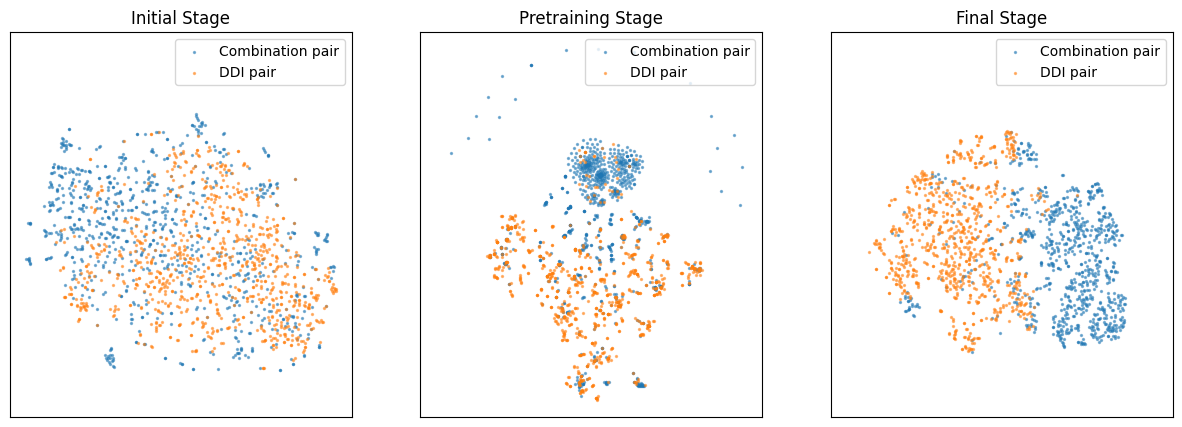

In [13]:
visualize(ts_testloader, reducer_name='tsne', ds_name='twosides', normalize=False)

emb_pos: torch.Size([860, 128]) / emb_neg: torch.Size([878, 128])
emb_pos: torch.Size([860, 128]) / emb_neg: torch.Size([878, 128])
emb_pos: torch.Size([860, 128]) / emb_neg: torch.Size([878, 128])
embedding: (1738, 2)
embedding: (1738, 2)
embedding: (1738, 2)


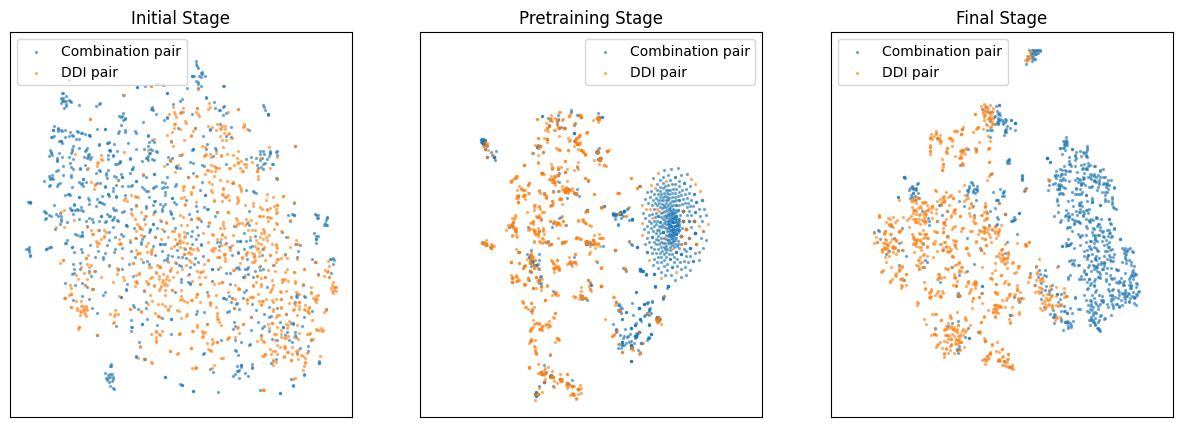

In [14]:
visualize(ts_testloader, reducer_name='tsne', ds_name='twosides', normalize=True)